# Определение перспективного тарифа для телеком компании

Федеральный оператор сотовой связи «Мегалайн» предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Постановка задачи

**Цель проекта** - определить, какой тариф выгоднее для "Мегалайна", на основе выборки из 500 пользователей.

Для этого необходимо:
1. Загрузить и проанализировать таблицы. Сформулировать перечень найденных ошибок в данных.
2. Провести предобработку данных: исправить ошибки, проанализировать пропуски, изменить типы данных. Добавить расчёты:
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя.
3. Описать поведение клиентов оператора, исходя из выборки. Определить, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц:
    - посчитать среднее количество, дисперсию и стандартное отклонение;
    - построить гистограммы;
    - описать распределения.
4. Проверить гипотезы:
    - средняя выручка пользователей тарифов "Ультра" и "Смарт" различается;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
5. Сформулировать общий вывод.

**Описание данных**

Таблица `users` (информация о пользователях):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

Таблица `calls` (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Загрузим все пять таблиц и посмотрим на несколько строк каждой.

In [2]:
users = pd.read_csv('datasets/users.csv')
users.sample(n=10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
236,1236,30,NaN,Москва,Леон,Демидов,2018-12-22,smart
234,1234,54,NaN,Магнитогорск,Роксана,Алексеева,2018-12-19,ultra
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
116,1116,65,NaN,Петрозаводск,Альберта,Шевцова,2018-04-17,smart
106,1106,67,NaN,Калуга,Исаак,Костин,2018-04-26,ultra
468,1468,29,NaN,Тамбов,Иван,Авдышев,2018-02-11,smart
448,1448,42,NaN,Кострома,Ростислав,Дроздов,2018-09-16,smart
281,1281,62,NaN,Нижний Новгород,Сара,Зимина,2018-06-09,ultra
134,1134,65,NaN,Красноярск,Марьяна,Авросимова,2018-01-16,smart
466,1466,37,NaN,Новосибирск,Рубен,Шевцов,2018-02-28,ultra


In [3]:
calls = pd.read_csv('datasets/calls.csv')
calls.sample(n=10)

,id,call_date,duration,user_id
132040,1340_14,2018-11-08,4.16,1340
101681,1262_38,2018-06-21,6.18,1262
1575,1005_172,2018-10-12,7.56,1005
121828,1314_501,2018-05-09,17.17,1314
135737,1346_287,2018-11-22,0.00,1346
199493,1491_452,2018-06-12,6.97,1491
186676,1460_594,2018-05-28,0.55,1460
89556,1224_473,2018-09-10,4.68,1224
63619,1161_135,2018-08-29,14.22,1161
189729,1466_744,2018-05-28,1.06,1466


In [4]:
messages = pd.read_csv('datasets/messages.csv')
messages.sample(n=10)

,id,message_date,user_id
1440,1004_494,2018-08-27,1004
53389,1236_45,2018-12-24,1236
99160,1404_300,2018-12-10,1404
33625,1146_423,2018-11-15,1146
23993,1099_200,2018-04-13,1099
45244,1196_694,2018-07-11,1196
409,1000_409,2018-12-17,1000
114153,1465_45,2018-06-09,1465
5564,1021_720,2018-05-08,1021
101334,1414_278,2018-07-26,1414


In [5]:
internet = pd.read_csv('datasets/internet.csv', index_col=0)
internet.sample(n=10)

,id,mb_used,session_date,user_id
109335,1373_257,325.18,2018-04-09,1373
94556,1319_256,373.96,2018-11-25,1319
146750,1491_22,199.90,2018-08-18,1491
65010,1221_123,1.82,2018-11-29,1221
76276,1255_472,172.28,2018-08-24,1255
130516,1435_124,152.22,2018-04-27,1435
48892,1169_7,85.79,2018-07-02,1169
88534,1299_451,858.41,2018-05-10,1299
14279,1050_106,891.98,2018-08-17,1050
49639,1171_341,0.00,2018-08-29,1171


In [6]:
tariffs = pd.read_csv('datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


1. В таблицах calls и internet есть нулевые значения потраченных минут и мегабайт соответственно. На общие суммы трафика и расходов эти нули не повлияют, но само наличие таких строк увеличивает количество сделанных звонков и интернет-сессий пользователями. Звонок продолжительностью 0 минут может означать, что пользователь звонил, но не дозвонился. Т.е. было намерение и попытка воспользоваться услугой. Эти нули всё равно показывают активность пользователей, поэтому их нужно оставить. Тогда при необходимости вычислить среднюю продолжительность звонка или средний объём интернет-сессии, нужно учитывать, что из общего количества звонков/сессий требуется вычесть количество их нулевых значений, чтобы не занижать среднее.
2. «Мегалайн» всегда округляет вверх значения минут и мегабайт, но в таблицах calls и internet приведены неокруглённые значения, что неудобно для дальнейших расчётов. Нужно округлить значения вверх и заменить тип данных на int.
3. В таблицах calls, messages и internet значения id содержат символ "_" среди чисел. Перед знаком подчёркивания находится уникальный id пользователя. Нижнее подчёркивание можно удалить, а тип столбцов преобразовать в int. При этом мы потеряем возможность по значению id однозначно видеть user_id, но связка этих значений сохранится в таблицах.

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


1. В столбце churn_date есть много незаполненных строк - это значит, что большая часть пользователей в выборке продолжает пользоваться выбранным тарифом. Необходимости заполнять такие пропуски нет.
2. Столбцы churn_date и reg_date содержат даты - нужно преобразовать тип данных.
3. У столбца tariff должно быть только два возможных значения на 500 пользователей: "smart" и "ultra" - это категориальный тип данных.

In [8]:
print('Варианты значений столбца tariff:', users['tariff'].unique())

Варианты значений столбца tariff: ['ultra' 'smart']


Неожиданных значений в столбце tariff нет.

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В таблицах calls, messages и internet пропущенных значений нет. Столбцы с датами в этих таблицах имеют тип object - нужно преобразовать в datetime.

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


У таблицы tariffs нет проблем с типами данных и пропусками.

В столбце city таблицы users содержатся названия городов. Если это значение попадало в таблицу из заполненной пользователем анкеты, то где-то может оказаться, что город написан с маленькой буквы, или найдётся другая проблема с регистром. Это нужно проверить.

In [13]:
print('Количество городов в таблице:', len(users['city'].unique()))
print('Количество городов, если записать всё в одном регистре:', len(users['city'].str.lower().unique()))

Количество городов в таблице: 76
Количество городов, если записать всё в одном регистре: 76


Проблем со значениями столбца city нет. Уникальных значений всего 76 - это значит, тип можно преобразовать в category.

Нужно проверить минимальные значения числовых столбцов таблиц, чтобы убедиться, что в них нет отрицательных, - это была бы явная ошибка.

In [14]:
print('Минимальный возраст в таблице: {} лет.'.format(users['age'].min()))
print('Минимальная продолжительность звонка: {} минут.'.format(calls['duration'].min()))
print('Минимальный интернет-трафик: {} мегабайт'.format(internet['mb_used'].min()))

Минимальный возраст в таблице: 18 лет.
Минимальная продолжительность звонка: 0.0 минут.
Минимальный интернет-трафик: 0.0 мегабайт


Отрицательных значений нет.

Нужно убедиться, что в таблицах нет повторяющихся строк.

In [15]:
print('Количество повторяющихся строк в users:', users.duplicated().sum())
print('Количество повторяющихся строк в calls:', calls.duplicated().sum())
print('Количество повторяющихся строк в messages:', messages.duplicated().sum())
print('Количество повторяющихся строк в internet:', internet.duplicated().sum())

Количество повторяющихся строк в users: 0
Количество повторяющихся строк в calls: 0
Количество повторяющихся строк в messages: 0
Количество повторяющихся строк в internet: 0


Дубликатов нет.

### Вывод

В данных есть следующие проблемы, которые нужно решить:
1. В таблицах calls и internet необходимо округлить значения столбцов duration и mb_used вверх.
2. В таблицах calls, messages и internet столбцы id содержат символ "_" среди чисел.
3. Необходимо преобразовать типы данных:
    - object в datetime:
        - users: churn_date, reg_date
        - calls: call_date
        - messages: message_date
        - internet: session_date
    - object в category:
        - users: tariff, city
    - obgect в int:
        - calls: id
        - messages: id
        - internet: id
    - float в int:
        - calls: duration
        - internet: mb_used


## Предобработка данных

### Исправление ошибок

Округлим значения столбцов duration и mb_used в большую сторону.

In [16]:
calls['duration'] = np.ceil(calls['duration'])
internet['mb_used'] = np.ceil(internet['mb_used'])

Для удаления "_" из значений id создадим функцию.

In [17]:
def impruvment_id (str_id):
    partitioned_id = str_id.partition('_')
    return partitioned_id[0] + partitioned_id[2]

В таблицах calls, messages и internet уберём "_" в id. Если количество уникальных значений id после этого уменьшится, то вернём старые id.

In [18]:
reserved_values_id = calls['id']
calls['id'] = calls['id'].apply(impruvment_id)

if len(reserved_values_id.unique()) != len(calls['id'].unique()):
    calls['id'] = reserved_values_id
    
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0.0,1000
1,10001,2018-08-17,0.0,1000
2,10002,2018-06-11,3.0,1000
3,10003,2018-09-21,14.0,1000
4,10004,2018-12-15,6.0,1000


In [19]:
reserved_values_id = messages['id']
messages['id'] = messages['id'].apply(impruvment_id)

if len(reserved_values_id.unique()) != len(messages['id'].unique()):
    messages['id'] = reserved_values_id
    
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [20]:
reserved_values_id = internet['id']
internet['id'] = internet['id'].apply(impruvment_id)

if len(reserved_values_id.unique()) != len(internet['id'].unique()):
    internet['id'] = reserved_values_id
    
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


Во всех трёх таблицах удалось привести id к числовым значениям.

**Вывод**

1. Количество потраченных минут и гигабайт округлено в большую сторону.
2. В таблицах calls, messages и internet значения id преобразованы в числа.

### Замена типа данных

Преобразуем даты в тип datetime во всех таблицах.

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

В таблице users тип данных столбцов tariff и city можно преобразовать в category.

In [22]:
users['tariff'] = users['tariff'].astype('category')
users['city'] = users['city'].astype('category')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    category      
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(2), datetime64[ns](2), int64(2), object(2)
memory usage: 27.3+ KB


В таблицах calls, messages и internet преобразуем id в int. Также в int преобразуем столбцы duration и mb_used.

In [23]:
calls['id'] = calls['id'].astype('int')
calls['duration'] = calls['duration'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


In [24]:
messages['id'] = messages['id'].astype('int')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [25]:
internet['id'] = internet['id'].astype('int')
internet['mb_used'] = internet['mb_used'].astype('int')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int64         
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.7 MB


**Вывод**

Все необходимые замены типов данных, описанные в разделе 2.1, проведены успешно. Тип object остался только для имени и фамилии пользователей. Тип float заменён полностью на int.

### Вывод

В таблицах исправлены ошибки и преобразованы типы данных: 
1. Удалён лишний столбец в таблице internet.
2. Количество потраченных минут и мегабайт округлены в большую сторону в соответствии с правилами оператора связи. Тип данных установлен int.
3. Даты преобразованы в тип данных datetime.
4. В таблицах calls, messages и internet id переведены в числовые значения.
5. Тип данных столбцов tariff и city таблицы users переопределён как category.

## Добавление результатов расчётов

Создадим таблицу `per_month_data` со следующими столбцами:
- *user_id* - уникальный идентификатор пользователя
- *month* - месяц от 1 до 12
- *calls_quantity* - количество сделанных звонков за месяц
- *calls_duration* - количество израсходованных минут разговора за месяц
- *messages_quantity* - количество отправленных сообщений за месяц
- *internet_used* - объем израсходованного интернет-трафика за месяц (в мегабайтах)
- *total_fee* - количество потраченных денег за месяц

Для удобства расчётов в таблицы calls, messages и internet добавим столбец month с номером месяца, соответствующим дате.

In [26]:
def month_from_date (date):
    return date.month

calls['month'] = calls['call_date'].apply(month_from_date)
messages['month'] = messages['message_date'].apply(month_from_date)
internet['month'] = internet['session_date'].apply(month_from_date)

Начнём создавать таблицу per_month_data: внесём в неё данные о звонках.

In [27]:
per_month_data = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['count','sum'])
per_month_data.columns = ['calls_quantity','calls_duration']
per_month_data.head(10)

calls_quantity  calls_duration
user_id month                                
1000    5                  22             159
        6                  43             172
        7                  47             340
        8                  52             408
        9                  58             466
        10                 57             350
        11                 43             338
        12                 46             333
1001    11                 59             430
        12                 63             414

Добавим данные о сообщениях.

In [28]:
per_month_data = per_month_data.join(messages.pivot_table(index=['user_id','month'], 
                                                          values='id', 
                                                          aggfunc='count'
                                                         ),
                                     how='outer'
                                    )
per_month_data.columns = ['calls_quantity','calls_duration','messages_quantity']
per_month_data.head(10)

calls_quantity  calls_duration  messages_quantity
user_id month                                                   
1000    5                22.0           159.0               22.0
        6                43.0           172.0               60.0
        7                47.0           340.0               75.0
        8                52.0           408.0               81.0
        9                58.0           466.0               57.0
        10               57.0           350.0               73.0
        11               43.0           338.0               58.0
        12               46.0           333.0               70.0
1001    11               59.0           430.0                NaN
        12               63.0           414.0                NaN

Добавим информацию об израсходованном интернет-трафике.

In [29]:
per_month_data = per_month_data.join(internet.pivot_table(index=['user_id','month'], 
                                                          values='mb_used', 
                                                          aggfunc='sum'
                                                         ),
                                     how='outer'
                                    )
per_month_data.columns = ['calls_quantity','calls_duration','messages_quantity','internet_used']
per_month_data.head(10)

calls_quantity  calls_duration  messages_quantity  \
user_id month                                                      
1000    5                22.0           159.0               22.0   
        6                43.0           172.0               60.0   
        7                47.0           340.0               75.0   
        8                52.0           408.0               81.0   
        9                58.0           466.0               57.0   
        10               57.0           350.0               73.0   
        11               43.0           338.0               58.0   
        12               46.0           333.0               70.0   
1001    11               59.0           430.0                NaN   
        12               63.0           414.0                NaN   

               internet_used  
user_id month                 
1000    5             2256.0  
        6            23257.0  
        7            14016.0  
        8            14070.0  
        9            14581.0  
        10           14717.0  
        11           14768.0  
        12            9827.0  
1001    11           18452.0  
        12           14053.0

Теперь значения индексов можно перенести в соответствующие столбцы.

In [30]:
per_month_data.reset_index(inplace=True)
per_month_data.head(10)

,user_id,month,calls_quantity,calls_duration,messages_quantity,internet_used
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0
5,1000,10,57.0,350.0,73.0,14717.0
6,1000,11,43.0,338.0,58.0,14768.0
7,1000,12,46.0,333.0,70.0,9827.0
8,1001,11,59.0,430.0,NaN,18452.0
9,1001,12,63.0,414.0,NaN,14053.0


В получившейся таблице могут быть незаполненные значения столбцов calls_quantity, calls_duration, messages_quantity и internet_used. Это означает, что конкретный пользователь в определённом месяце соответствующей услугой не пользовался. Значит, пропуски означают 0: 0 звонков, 0 минут, 0 сообщений, 0 мегабайт соответственно.

In [31]:
per_month_data = per_month_data.fillna(0)
per_month_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month              3214 non-null   int64  
 2   calls_quantity     3214 non-null   float64
 3   calls_duration     3214 non-null   float64
 4   messages_quantity  3214 non-null   float64
 5   internet_used      3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


Тип данных столбцов calls_quantity, calls_duration, messages_quantity и internet_used должен быть int.

In [32]:
per_month_data['calls_quantity'] = per_month_data['calls_quantity'].astype('int')
per_month_data['calls_duration'] = per_month_data['calls_duration'].astype('int')
per_month_data['messages_quantity'] = per_month_data['messages_quantity'].astype('int')
per_month_data['internet_used'] = per_month_data['internet_used'].astype('int')

Теперь посчитаем, сколько каждый пользователь тратил денег в месяц, исходя из информации о тарифах. Для удобства расчётов добавим в таблицу per_month_data столбец tariff, а для дальнейшего анализа - столбец city.

In [33]:
per_month_data = per_month_data.join(users.set_index('user_id')[['tariff','city']], on='user_id')

Потраченные деньги складываются из следующих величин:
- Ежемесячная абонентская плата.
- Стоимость дополнительных звоков по формуле: ("количество минут разговора в месяц" - "количество минут в тарифном пакете") * "стоимость одной минуты"
- Стоимость дополнительных сообщений по аналогичной формуле.
- Стоимость дополнительного интернета, который продаётся гигабайтами. Т.е. если основной пакет израсходован, то пользователь покупает сразу 1024 мегабайт, а не по одному, как с минутами или сообщениями. Поэтому формула здесь будет другая: ceil(("израсходованный трафик в месяц" - "количество мегабайт в тарифном пакете") / 1024) * "стоимость одного гигабайта"

In [34]:
tariffs = tariffs.set_index('tariff_name')

def calc_total_fee (row):
    tariff = row['tariff']
    total_fee = tariffs.loc[tariff,'rub_monthly_fee']
    
    total_fee += np.where(row['calls_duration'] > tariffs.loc[tariff,'minutes_included'],
                          (row['calls_duration'] - tariffs.loc[tariff,'minutes_included']) * tariffs.loc[tariff,'rub_per_minute'],
                          0
                         )
    total_fee += np.where(row['messages_quantity'] > tariffs.loc[tariff,'messages_included'],
                          (row['messages_quantity'] - tariffs.loc[tariff,'messages_included']) * tariffs.loc[tariff,'rub_per_message'],
                          0
                         )
    total_fee += np.where(row['internet_used'] > tariffs.loc[tariff,'mb_per_month_included'],
                          np.ceil((row['internet_used'] - tariffs.loc[tariff,'mb_per_month_included']) / 1024) * tariffs.loc[tariff,'rub_per_gb'],
                          0
                         )    
    return total_fee
    
per_month_data['total_fee'] = per_month_data.apply(calc_total_fee, axis=1)
per_month_data.sample(n=10)

,user_id,month,calls_quantity,calls_duration,messages_quantity,internet_used,tariff,city,total_fee
1239,1193,3,78,612,8,11569,smart,Тамбов,886.0
3096,1480,4,79,550,20,15424,smart,Новокузнецк,900.0
2541,1395,11,91,637,26,19206,smart,Москва,1761.0
3010,1468,10,26,195,14,13964,smart,Тамбов,550.0
2437,1382,5,95,625,88,14213,ultra,Самара,1950.0
1310,1204,6,45,325,0,19822,smart,Москва,1550.0
1409,1221,7,20,114,32,8981,smart,Белгород,550.0
150,1021,9,150,1115,113,18321,ultra,Краснодар,1950.0
2597,1404,7,27,142,48,19509,smart,Иркутск,1550.0
1387,1217,12,85,607,78,13174,smart,Ульяновск,955.0


In [35]:
per_month_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            3214 non-null   int64   
 1   month              3214 non-null   int64   
 2   calls_quantity     3214 non-null   int64   
 3   calls_duration     3214 non-null   int64   
 4   messages_quantity  3214 non-null   int64   
 5   internet_used      3214 non-null   int64   
 6   tariff             3214 non-null   category
 7   city               3214 non-null   category
 8   total_fee          3214 non-null   float64 
dtypes: category(2), float64(1), int64(6)
memory usage: 184.9 KB


Все расчёты добавлены в таблицу. Пропусков и проблем с типами данных нет.

### Вывод

Создана таблица per_month_data с информацией по ежемесячному расходованию минут, сообщений и интернета для каждого пользователя. Кроме того, в таблице есть информация о тарифе, городе и о фактически потраченных деньгах в месяц.

## Анализ данных

В таблице per_month_data содержится информация по месяцам для разных пользователей разных тарифов. Но нам нужно проанализировать данные по 500 пользователям, а не по множеству человекомесяцев. Посчитаем среднее ежемесячное потребление услуг для каждого пользователя отдельно.

In [36]:
mean_month_data = per_month_data.pivot_table(index='user_id',
                                             aggfunc={'tariff': 'first',
                                                      'city': 'first',
                                                      'calls_duration': 'mean',
                                                      'messages_quantity': 'mean',
                                                      'internet_used': 'mean',
                                                      'total_fee': 'mean'
                                                     }
                                            ).reset_index()
mean_month_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            498 non-null    int64  
 1   calls_duration     498 non-null    float64
 2   city               498 non-null    object 
 3   internet_used      498 non-null    float64
 4   messages_quantity  498 non-null    float64
 5   tariff             498 non-null    object 
 6   total_fee          498 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 27.4+ KB


Получилась таблица с 498-ю строками. Похоже, из выборки в 500 человек двое не пользуются услугами связи. Нужно добавить их в таблицу, потому что нулевые значения потребления повлияют на среднее, к тому же они могли платить абонентскую плату. Посмотрим на этих пользователей.

In [37]:
two_users = users[~users['user_id'].isin(mean_month_data['user_id'])].reset_index()
two_users

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
1,371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Видно, что эти пользователи подключали тариф всего на несколько дней. Обычно первый месяц после подключения тарифа абонентская плата делится на количество дней и снимается ежедневно, поэтому будем считать, что эти пользователи не платили полную стоимость за месяц.

In [38]:
per_month_data.columns

Index(['user_id', 'month', 'calls_quantity', 'calls_duration',
       'messages_quantity', 'internet_used', 'tariff', 'city', 'total_fee'],
      dtype='object')

In [39]:
per_month_data.loc[len(per_month_data)] = [two_users.loc[0,'user_id'],
                                           two_users.loc[0,'churn_date'].month,
                                           0,0,0,0,
                                           two_users.loc[0,'tariff'],
                                           two_users.loc[0,'city'],
                                           np.ceil(tariffs.loc[two_users.loc[0,'tariff'],'rub_monthly_fee'] * ((two_users.loc[0,'churn_date'] - two_users.loc[0,'reg_date']).days + 1) / 31)
                                          ]
per_month_data.loc[len(per_month_data)] = [two_users.loc[1,'user_id'],
                                           two_users.loc[1,'churn_date'].month,
                                           0,0,0,0,
                                           two_users.loc[1,'tariff'],
                                           two_users.loc[1,'city'],
                                           np.ceil(tariffs.loc[two_users.loc[1,'tariff'],'rub_monthly_fee'] * ((two_users.loc[1,'churn_date'] - two_users.loc[1,'reg_date']).days + 1) / 31)
                                          ]
per_month_data.tail()

,user_id,month,calls_quantity,calls_duration,messages_quantity,internet_used,tariff,city,total_fee
3211,1499,10,68,449,48,17809,smart,Пермь,1150.0
3212,1499,11,74,612,59,17984,smart,Пермь,1513.0
3213,1499,12,69,492,66,13077,smart,Пермь,598.0
3214,1128,12,0,0,0,0,ultra,Волжский,567.0
3215,1371,12,0,0,0,0,smart,Омск,107.0


Пересчитаем mean_month_data.

In [40]:
mean_month_data = per_month_data.pivot_table(index='user_id',
                                             aggfunc={'tariff': 'first',
                                                      'city': 'first',
                                                      'calls_duration': 'mean',
                                                      'messages_quantity': 'mean',
                                                      'internet_used': 'mean',
                                                      'total_fee': 'mean'
                                                     }
                                            ).reset_index()
mean_month_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            500 non-null    int64  
 1   calls_duration     500 non-null    float64
 2   city               500 non-null    object 
 3   internet_used      500 non-null    float64
 4   messages_quantity  500 non-null    float64
 5   tariff             500 non-null    object 
 6   total_fee          500 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 27.5+ KB


Посчитаем среднее значение, дисперсию и стандартное отклонение для потребляемых минут, сообщений и интернета.

In [41]:
mean_calls_data = mean_month_data.pivot_table(index='tariff',
                           values='calls_duration',
                           aggfunc=[np.mean,
                                    np.var, #Здесь ddof=1 по умолчанию
                                    np.std]
                          )
mean_calls_data

,mean,var,std
,calls_duration,calls_duration,calls_duration
tariff,,,
smart,418.439262,21475.741546,146.546039
ultra,524.279391,80736.812324,284.142240


In [42]:
mean_messages_data = mean_month_data.pivot_table(index='tariff',
                           values='messages_quantity',
                           aggfunc=[np.mean,
                                    np.var,
                                    np.std]
                          )
mean_messages_data

,mean,var,std
,messages_quantity,messages_quantity,messages_quantity
tariff,,,
smart,32.259907,703.883524,26.530803
ultra,53.668121,2154.895683,46.420854


In [43]:
mean_internet_data = mean_month_data.pivot_table(index='tariff',
                           values='internet_used',
                           aggfunc=[np.mean,
                                    np.var,
                                    np.std]
                          )
mean_internet_data

,mean,var,std
,internet_used,internet_used,internet_used
tariff,,,
smart,16155.230119,1.355361e+07,3681.522658
ultra,19461.343437,7.131046e+07,8444.552074


Посмотрим, что входит в предоплаченные пакеты услуг.

In [44]:
tariffs[['messages_included', 'mb_per_month_included', 'minutes_included']]

,messages_included,mb_per_month_included,minutes_included
tariff_name,,,
smart,50,15360,500
ultra,1000,30720,3000


Видно, что пользователи тарифа "Ультра" потребляют в среднем больше услуг, но и стандартное отклонение у значений этого тарифа выше, чем у "Смарт". При этом средние значения отличаются друг от друга не так сильно, как значения в описании тарифов. Т.е. в среднем пользователи "Ультры" превосходят по потреблению услуг пользователей "Смарт" не так значительно, как это предусмотрено тарифом. Но из-за большой дисперсии нельзя делать какие-то выводы по средним значениям.

Посмотрим гистограммы. Будем использовать плотностные гистограммы, т.к. средние значения минут, сообщений и мегабайт могут принимать любые, не повторяющиеся значения. Согласно центральной предельной теореме распределения должны быть нормальными. Для ориентира, чтобы было с чем сравнивать, изобразим в осях координат графики нормальных распределений с высчитанными выше параметрами.

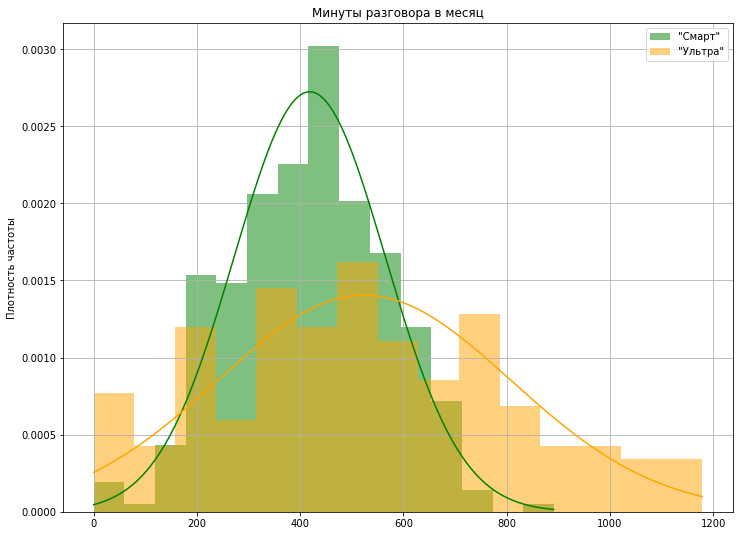

In [45]:
def multiplot (parameter, plot_title, mean_smart, std_smart, mean_ultra, std_ultra):
    ax = mean_month_data[mean_month_data['tariff'] == 'smart'].plot(
        y=parameter,
        kind='hist',
        density=True,
        bins=15,
        alpha=0.5,
        color='green',
        figsize=(12, 9),
        grid=True,
        legend=True,
        title=plot_title,
        label='"Смарт"'
    )
    mean_month_data[mean_month_data['tariff'] == 'ultra'].plot(
        y=parameter,
        kind='hist',
        density=True,
        bins=15,
        alpha=0.5,
        color='orange',
        figsize=(12, 9),
        grid=True,
        legend=True,
        title=plot_title,
        label='"Ультра"',
        ax=ax
    )

    x_smart = range(int(np.floor(mean_month_data[mean_month_data['tariff'] == 'smart'][parameter].min())),
                    int(np.ceil(mean_month_data[mean_month_data['tariff'] == 'smart'][parameter].max()))
                   )
    norm_smart = st.norm.pdf(x_smart, mean_smart, std_smart)

    x_ultra = range(int(np.floor(mean_month_data[mean_month_data['tariff'] == 'ultra'][parameter].min())),
                    int(np.ceil(mean_month_data[mean_month_data['tariff'] == 'ultra'][parameter].max()))
                   )
    norm_ultra = st.norm.pdf(x_ultra, mean_ultra, std_ultra)

    plt.plot(norm_smart, 'g-', color='green')
    plt.plot(norm_ultra, 'g-', color='orange')
    plt.ylabel('Плотность частоты')
    plt.show()

multiplot (parameter='calls_duration',
           plot_title='Минуты разговора в месяц',
           mean_smart = mean_calls_data.loc['smart',('mean','calls_duration')],
           std_smart = mean_calls_data.loc['smart',('std','calls_duration')],
           mean_ultra = mean_calls_data.loc['ultra',('mean','calls_duration')],
           std_ultra = mean_calls_data.loc['ultra',('std','calls_duration')]
          )

Распределения нормальные. У пользователей тарифа "Ультра" разброс среднего значения количества использованных минут в месяц больше, чем у пользователей тарифа "Смарт". Нужно отметить, что при этом пользователи "Ультры" укладываются в предоставленные в тарифе 3000 минут и дополнительные минуты не докупают, тогда как почти половина пользователей "Смарта" превышают предоплаченный лимит в 500 минут и дальше переходят на поминутную тарификацию.

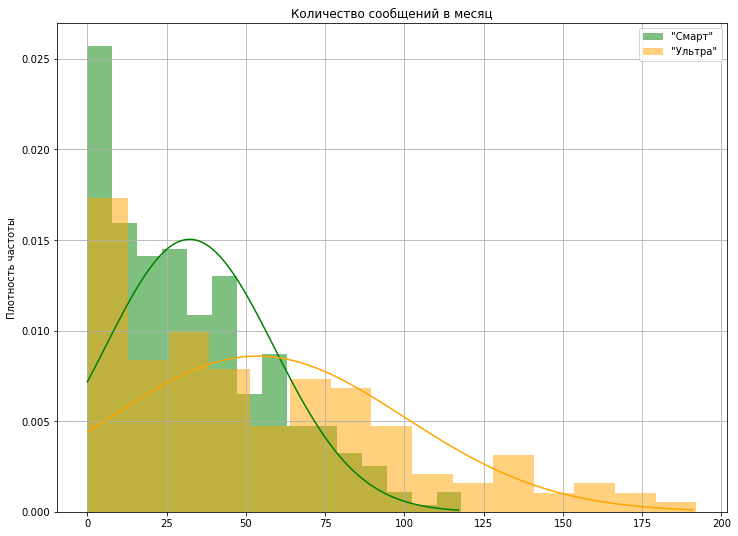

In [46]:
multiplot (parameter='messages_quantity',
           plot_title='Количество сообщений в месяц',
           mean_smart = mean_messages_data.loc['smart',('mean','messages_quantity')],
           std_smart = mean_messages_data.loc['smart',('std','messages_quantity')],
           mean_ultra = mean_messages_data.loc['ultra',('mean','messages_quantity')],
           std_ultra = mean_messages_data.loc['ultra',('std','messages_quantity')]
          )

На графике видно, как гистограммы слева отклоняются от нормальных значений, правые половины - нормальные. Это показывает, что среди пользователей есть тенденция отказываться от использования смс-сообщений. Количество людей, которые отправляют близкое к нулю число сообений, сопоставимо с количеством людей, отправляющих больше ста смс в месяц. Пользователям "Ультры" хватает пакетных 1000 сообщений на месяц, а часть пользователей "Смарта" покупает дополнительные смс, превысив выделенные 50.

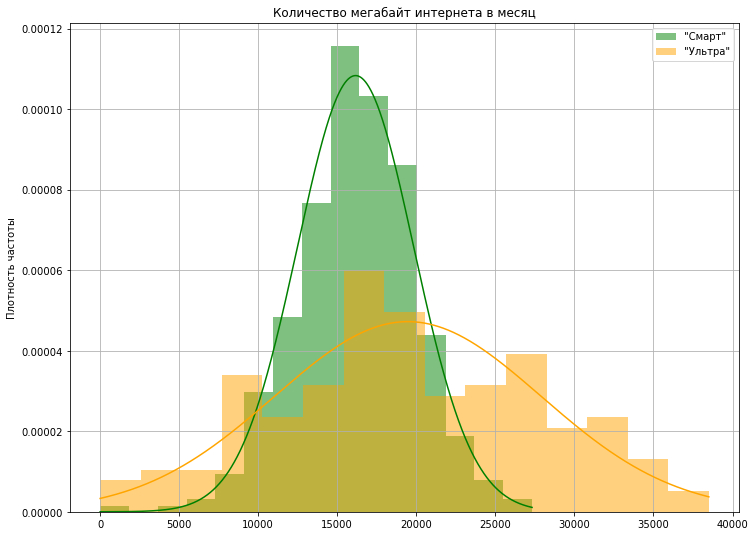

In [47]:
multiplot (parameter='internet_used',
           plot_title='Количество мегабайт интернета в месяц',
           mean_smart = mean_internet_data.loc['smart',('mean','internet_used')],
           std_smart = mean_internet_data.loc['smart',('std','internet_used')],
           mean_ultra = mean_internet_data.loc['ultra',('mean','internet_used')],
           std_ultra = mean_internet_data.loc['ultra',('std','internet_used')]
          )

Потребление интернета распределяется нормально. Как и в других случаях, у пользователей "Ультры" больше разброс значений. Половине пользователей тарифа "Смарт" недостаточно предоставляемых 15 гигабайт в месяц. Части пользователей "Ультры" тоже приходится докупать интернет сверх предоплаченных 30 гигабайт.

### Вывод

Пользователям тарифа "Смарт" недостаточно минут и гигабайт в пакете: половине приходится докупать ещё. Части пользователей не хватает и предоставленных 50-и смс в месяц. Пользователи же тарифа "Ультра" в основном укладываются в предоплаченный пакет, но некоторым приходится дополнительно докупать трафик сверх 30-и гигабайт. Кроме того, среди пользователей обоих тарифов есть необычно много людей, которые почти не пользуются смс. 

Средние значения минут разговора, количества сообщений и мегабайт интернет-трафика в месяц приведены в таблице ниже. В ней же и значение среднемесячных расходов.

In [48]:
np.round((mean_month_data.groupby('tariff')[['calls_duration',
                                   'messages_quantity',
                                   'internet_used',
                                   'total_fee'
                                  ]]).apply(np.mean), 2)

,calls_duration,messages_quantity,internet_used,total_fee
tariff,,,,
smart,418.44,32.26,16155.23,1326.24
ultra,524.28,53.67,19461.34,2077.21


## Проверка гипотез

### Сравнение пользователей тарифов «Ультра» и «Смарт»

Пользователи тарифов "Ультра" и "Смарт" по-разному оплачивают услуги: большинству пользователей "Ультры" достаточно предоставляемых на месяц пакетов услуг, а среди пользователей "Смарта" по крайней мере половине приходится докупать дополнительные услуги, поэтому их расходы выше, чем ежемесячная абонентская плата. Но разница в стоимости тарифов достаточно велика, чтобы предположить, что средние траты пользователей "Ультры" и "Смарта" различаются, не смотря на дополнительные траты вторых. 

Чтобы это проверить, сформулируем нулевую гипотезу H<sub>0</sub>: "Средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" равны". Если эта гипотеза окажется опровергнутой, то можно будет считать верной альтернативную гипотезу H<sub>1</sub>: "Средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" отличаются".

Чтобы проверить H<sub>0</sub>, посчитаем вероятность получить такую выборку из 500 пользователей, которая у нас есть, исходя из предположения, что гипотеза H<sub>0</sub> верна. Если получившаяся вероятность будет меньше порогового значения alpha, то гипотеза будет опровергнута. Это будет означать, что из генеральной совокупности нельзя было бы выделить нашу выборку. Если вероятность окажется выше alpha, то сделать какой-то вывод о гипотезе будет нельзя. Т.к. выборка достаточно большая - 500 человек, то установим пороговое значение alpha=1%. 

Исходя из картины трат в выборке, можно предположить, что дисперсии генеральных совокупностей пользователей разных тарифов различаются: пользователи "Ультры" в основном оплачивают только абонентскую плату, а пользователи "Смарта" докупают услуги.

In [49]:
alpha = 0.01
p_value = st.ttest_ind(mean_month_data[mean_month_data['tariff'] == 'ultra']['total_fee'],
                       mean_month_data[mean_month_data['tariff'] == 'smart']['total_fee'],
                       equal_var=False
                      ).pvalue

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" отличаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Нулевая гипотеза опровергнута.
Средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" отличаются.


**Вывод**

Проведённый t-тест показал, что у пользователей разных тарифов отличаются траты. Для теста мы считали дисперсии выборок различными, а пороговое значение alpha=1%.

### Сравнение пользователей из Москвы и из других регионов

Аналогично сравним траты пользователей из Москвы и из других городов. Для выборки по-прежнему будем считать пороговое значение alpha=1%. А вот дисперсии для жителей различных городов, скорее всего, одинаковые.

Нулевая гипотеза H<sub>0</sub>: "Средние ежемесячные траты пользователей из Москвы и пользователей из других городов равны". 

Альтернативная гипотеза H<sub>1</sub>: "Средние ежемесячные траты пользователей из Москвы и пользователей из других городов отличаются".

In [50]:
p_value = st.ttest_ind(mean_month_data[mean_month_data['city'] == 'Москва']['total_fee'],
                       mean_month_data[mean_month_data['city'] != 'Москва']['total_fee'],
                       equal_var=True
                      ).pvalue

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Средние ежемесячные траты пользователей из Москвы и пользователей из других городов отличаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Не получилось отвергнуть нулевую гипотезу.
p-value = 42.46%


**Вывод**

Нельзя точно сказать что-то о различиях в тратах пользователей из Москвы и из других городов. Выборка не противоречит предположению, что траты равны.

### Вывод

После проведённых t-тестов можно сказать:
1. Средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" отличаются.
2. Выборка не противоречит предположению, что средние ежемесячные траты пользователей из Москвы и пользователей из других городов равны.

Пороговое значение alpha было выбрано 1%. Для проверки первой гипотезы дисперсии считались различными, а для проверки второй - одинаковыми.

## Общий вывод

В работе была проанализирована выборка из 500 пользователей "Мегалайна": уровень потребления услуг и расходы за 2018 год. 

Установлено, что большинство пользователей тарифа "Ультра" не докупает дополнительные услуги, однако части из них приходится доплачивать за интернет-трафик свыше 30 гигабайт. У пользователей тарифа "Смарт" другая картина: около половины пользователей платит за дополнительный трафик и/или минуты разговора, части пользователей не хватает 50 смс-сообщений на месяц. При этом независимо от тарифа существует достаточное количество пользователей, почти не использующих услугу смс.

Не смотря на покупку дополнительных услуг, в представленной выборке среднее значение оплаченных услуг в месяц у пользователей тарифа "Смарт" меньше, чем у пользователей тарифа "Ультра". Проведённый t-тест показывает, что в генеральной совокупности средние ежемесячные траты пользователей тарифов "Ультра" и "Смарт" отличаются. 

По представленной выборке нельзя определённо судить, как зависят траты от места жительства пользователя. Выборка не противоречит предположению, что средние ежемесячные траты пользователей из Москвы и пользователей из других городов равны.

Тариф "Ультра" дороже и большинству пользователей хватает предоплаченного пакета услуг. Тариф "Смарт" дешевле, но по меньшей мере половине пользователей приходится дополнительно докупать услуги, значит, в перспективе они могут сменить тариф на более подходящий. Можно сказать, для "Мегалайна" выгоднее тариф "Ультра".